In [1]:
import sys
import os
sys.path.append("../src/whole_history_rating")
from whr import whole_history_rating
from whr import utils
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from scipy.optimize import curve_fit

In [2]:
data_path = '../data/cfbd/games_1990_to_2020.csv'

In [3]:
games_df = pd.read_csv(data_path)
games_df_test = games_df[games_df.season<2015]
games_df_verify = games_df[games_df.season>=2015]
games_df.shape

(23256, 25)

In [288]:
datetime_from_cfbd = lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ")
mean_and_error = lambda x: (np.mean(x), np.std(x)/(len(x) ** 2))
abs_mean_and_error = lambda x: (np.mean(np.abs(x)), np.std(x)/(len(x) ** 2))
abeError = lambda x: mean_and_error(np.abs(x))
date_from_cfbd = lambda x: datetime_from_cfbd(x).strftime('%Y-%m-%d')

In [99]:
def get_dates_df(df):
    date_dict = {}
    dates = df.start_date.to_numpy()
    dates_string = list(map(date_from_cfbd,dates))
    dates_string_list = []
    for date,date_string in zip(dates,dates_string):
        if date_string not in date_dict: 
            date_dict[date_string] = []
            dates_string_list.append(date_string)
            date_dict[date_string].append(date)
    return date_dict,dates_string_list

In [187]:
def make_preditiction(whr,date):
    at,ht,_,_,_,handicap = date
    away_rating, away_unc = whr.ratings_for_player(at,current=True)
    home_rating, home_unc = whr.ratings_for_player(ht,current=True)
    if away_rating and home_rating:
        return home_rating-away_rating+handicap, (away_unc ** 2 + home_unc **2 ) ** .5
    return None

In [ ]:
def make_preditictions(whr,date_list):
    pred_list = []
    for at,ht,_,_,_,handicap in date_list:
        away_rating, away_unc = whr.ratings_for_player(at,current=True)
        home_rating, home_unc = whr.ratings_for_player(ht,current=True)
        if away_rating and home_rating:
            pred_list.append(home_rating-away_rating+handicap)
        else:
            pred_list.append(None)
    return pred_list

In [264]:
def compare_spread_prediction(whr, date_list):
    pred_list = []
    for date in date_list:
        _,_,ap,hp,dd,_ = date
        spread = hp-ap
        prediction = make_preditiction(whr,date)
        if not prediction==None:
            pred_list.append([spread,*prediction ,dd])
    return pred_list

In [291]:
def score_predictions(predictions):
    abe_list = []
    correct_list = []
    for spread,pred,_,_ in predictions:
        abe_list.append(abs(spread-pred))
        correct_list.append(spread*pred>0)
    return mean_and_error(correct_list), abs_mean_and_error(abe_list)

In [283]:
def iterate_by_day(df,whr,handicap=2.5, time_offset=10, max_day_delta = 300):
    date_dict,dates_string_list = get_dates_df(df)
    first_date = datetime_from_cfbd(date_dict[dates_string_list[0]][0])
    day_delta = 0
    prediction_list = []
    for dates in dates_string_list:
        after_offset =  day_delta > time_offset
        #before day
        if after_offset: 
            whr.auto_iterate(time_limit = 10, precision = 10E-3)
        #middle day
        date_list = []
        for date in date_dict[dates]:
            current_date = datetime_from_cfbd(date)
            day_delta = (current_date-first_date).days

            games_day = df[df.start_date==date]
            games_day_list = games_day[['away_team','home_team','away_points','home_points', 'neutral_site']].values.tolist()
            date_list+=games_day_list
        date_list = [[at,ht,ap,hp,day_delta,handicap*(1-ns)] for at,ht,ap,hp,ns in date_list]

        if after_offset:
            prediction_list+=compare_spread_prediction(whr, date_list)
        for game in date_list:
            whr.create_game(*game)
        if max_day_delta < day_delta: return prediction_list
    return prediction_list
        #end day

In [267]:
def benchmark_w2(df, default_w2, verbose=False, time_offset=10, max_events=-1,popt=[]):
    n_games = games_df_test.shape[0]
    n_iter_games = 0
    n_pred_games = 0
    correct_prediction_list = []
    delta_mov_list = []
    pred_list = []
    mov_list = []
    
    scale = 16
    mov_SF = 16/scale
    whr = whole_history_rating.Base({'scale': scale,'w2':default_w2, 'debug':False})
    start_time = 0
    home_team_handicap = 2.5/13*scale
    current_day,day_delta=0,0
    
    pred_list = iterate_by_day(df,whr,time_offset=time_offset)

    return pred_list


In [297]:
start = time.perf_counter()
w2_list = []
per_corr_list = []
per_corr_unc_list = []
abe_list = []
abe_unc_list = []
mov_list_list = []
pred_mov_list_list = []
log_min, log_max = 3, 5
log_space = np.logspace(log_min, log_max,10)
lin_space = np.linspace(log_min, log_max,10)

for w2,w2_power in zip(log_space,lin_space):
    print("w2 value: {}, w2 power: {}".format(w2, w2_power))
    predictions = benchmark_w2(games_df,w2,time_offset=800,max_events=850)
    print(len(predictions))
    (correct, correct_err),(abe,abe_err) = score_predictions(predictions)

    w2_list.append(w2)
    per_corr_list.append(correct)
    per_corr_unc_list.append(correct_err)
    abe_list.append(abe)
    abe_unc_list.append(abe_err)
    mid_time = time.perf_counter()
    print("{:.2f}% corr, abe: {:.2f}".format(correct*100,abe))
    print("{:.2f} seconds elapsed".format(mid_time-start))
end = time.perf_counter()
end-start

w2 value: 1000.0, w2 power: 3.0
480
67.71% corr, abe: 14.78
23.69 seconds elapsed
w2 value: 1668.100537200059, w2 power: 3.2222222222222223
483
66.67% corr, abe: 15.10
48.07 seconds elapsed
w2 value: 2782.559402207126, w2 power: 3.4444444444444446
929.3513360949172
Oregon State
[<whr.playerday.PlayerDay object at 0x7f1ca7d1f130>, <whr.playerday.PlayerDay object at 0x7f1ca606f190>, <whr.playerday.PlayerDay object at 0x7f1ca5908e80>, <whr.playerday.PlayerDay object at 0x7f1ca5be2730>, <whr.playerday.PlayerDay object at 0x7f1ca4e38d30>, <whr.playerday.PlayerDay object at 0x7f1ca5fd5100>]
-7 Oregon State Montana
26 Kansas Oregon State
-25 Oregon State UNLV
34 Stanford Oregon State
24 Nebraska Oregon State
14 Oregon State Arizona


AttributeError: bad adjusted gamma

In [298]:
(correct, correct_err),(abe,abe_err)

((0.6666666666666666, 2.020689020018225e-06),
 (15.102484472049689, 4.935309012306303e-05))

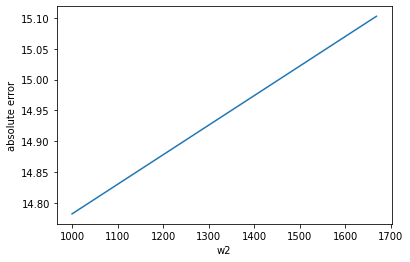

In [299]:
plt.errorbar(w2_list,abe_list,yerr=abe_unc_list)
plt.ylabel("absolute error")
plt.xlabel("w2")
plt.savefig("mov_abe_v_w2_{}_to_{}.png".format(log_min, log_max))

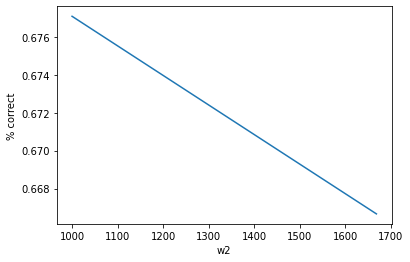

In [300]:
plt.errorbar(w2_list,per_corr_list,yerr=per_corr_unc_list)
plt.ylabel("% correct")
plt.xlabel("w2")
plt.savefig("mov_percent_corr_v_w2_{}_to_{}.png".format(log_min, log_max))

In [76]:
def linear_func(x,m,b):
    return m * x + b

In [77]:
x,y = pred_mov_list_list[5],mov_list_list[5]
popt,pcov = curve_fit(linear_func,x,y)
popt, pcov

(array([1.13675681, 1.49557498]),
 array([[ 0.00360343, -0.01815795],
        [-0.01815795,  0.48608336]]))

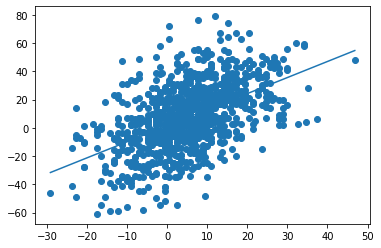

In [78]:
x_space = np.linspace(np.min(x), np.max(x),100)
y_pred = linear_func(x_space,*popt)
plt.scatter(x,y)
plt.plot(x_space,y_pred)

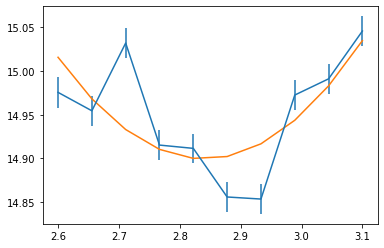

In [67]:
abes = []
abes_unc = []
for x,y, exp in zip(pred_mov_list_list,mov_list_list,lin_space):
    popt,pcov = curve_fit(linear_func,x,y)
    popt, pcov
    y_scaled = linear_func(x,*popt)
    abe,abe_unc = (abeError(y_scaled-y))
    abes.append(abe)
    abes_unc.append(abe_unc)
    
space = lin_space
plt.errorbar(space,abes,yerr=abes_unc)

def quadratic_func(x,a,b,c):
    return a * x **2 + b * x + c

popt,pconv = curve_fit(quadratic_func,space,abes)

y_pred = quadratic_func(space,*popt)
plt.plot(space,y_pred)

array([ 7.16020905e-07, -1.11718554e-03,  1.53323731e+01])

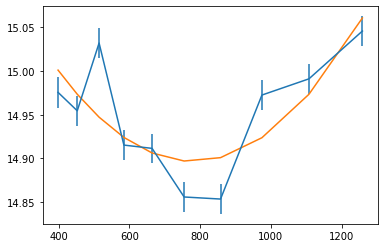

In [69]:
space = log_space
plt.errorbar(space,abes,yerr=abes_unc)

def quadratic_func(x,a,b,c):
    return a * x **2 + b * x + c

popt,pconv = curve_fit(quadratic_func,space,abes)

y_pred = quadratic_func(space,*popt)
plt.plot(space,y_pred)

popt

In [ ]:
max_events = [100,300,500]
total_time = [13.94,174,326.60867288500594]
plt.plot(max_events,total_time)

In [78]:
start_time=0
for i,row in games_df_test.iterrows():
        game_time = datetime_from_cfbd(row.start_date)
        if start_time == 0: start_time = game_time
        day_delta = (game_time-start_time).days
day_delta, day_delta/games_df_test.shape[0]

(8905, 0.4866386141319198)

In [79]:
.4866386141319198*1000

486.6386141319198

In [38]:
np.logspace(2.6, 3.1,10)

array([ 398.10717055,  452.43433466,  514.17518277,  584.34141337,
        664.08278506,  754.7059567 ,  857.69589859,  974.74022556,
       1107.75685051, 1258.92541179])